In [17]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics

In [18]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [19]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        #维数 seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        #维数 dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        #维数 seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #维数 1Xseq_lenXd_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        #print("x:",x.shape)
        #print("pe:",self.pe.shape)
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

In [20]:
class FourierBlock(nn.Module):
    def __init__(self, input_dim, mlp_dim, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, input_dim),
            nn.Dropout(dropout)
        )
        self.norm_1 = nn.LayerNorm(input_dim)
        self.norm_2 = nn.LayerNorm(input_dim)

    def fourier_transform(self, x):
        return torch.fft.fft(x, dim=-1).real

    def forward(self, x):
        residual = x
        x = self.fourier_transform(x)
        x = self.norm_1(x + residual)
        residual = x
        x = self.mlp(x)
        out = self.norm_2(x + residual)
        return out

In [21]:
class IsometricConvBlock(nn.Module):
    def __init__(self,input_dim,mlp_dim,input_length,dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, input_dim),
            nn.Dropout(dropout)
        )
        self.norm_1 = nn.LayerNorm(input_dim)
        self.norm_2 = nn.LayerNorm(input_dim)
        #Conv1d要求输入为batch_size*features*seq_length
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=input_dim,
                              kernel_size=input_length,padding=0,stride=1,groups=3)
    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv(x)
        return out

    def forward(self,x):
        #input : batch_size seq_len feature_size
        residual = x
        x  = x.permute(0,2,1)
        #batch_size feature_size seq_len
        x = self.isometric_conv(x)
        x = x.permute(0,2,1)
        x = self.norm_1(x + residual)
        residual = x
        x = self.mlp(x)
        out = self.norm_2(x + residual)
        return out

In [22]:
class DiflNet(nn.Module):
    def __init__(self,num_i,num_f,feature_dim,mlp_dim,seq_len):
        super().__init__()
        self.pe = PositionalEncoding(3)
        self.IsometricConvList = nn.ModuleList([IsometricConvBlock(feature_dim,mlp_dim,seq_len) for _ in range(num_i)])
        self.FourierList =  nn.ModuleList([FourierBlock(feature_dim,mlp_dim) for _ in range(num_f)])
        self.channel_interaction_i = nn.Sequential(
            nn.Linear(in_features=feature_dim,out_features=feature_dim*16),
            nn.GELU(),
            nn.Linear(in_features=feature_dim*16,out_features=1),
            nn.Dropout(0.3)
        )
        self.channel_interaction_f = nn.Sequential(
            nn.Linear(in_features=feature_dim,out_features=feature_dim*16),
            nn.GELU(),
            nn.Linear(in_features=feature_dim*16,out_features=1),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=seq_len*2,out_features=seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.norm_i = nn.LayerNorm(feature_dim)
        self.norm_f = nn.LayerNorm(feature_dim)
        
    
    def forward(self,x):
        x = x+self.pe(x)
        residual = x
        for Iblock in self.IsometricConvList:
            i_features = Iblock(x)
            
        for Fblock in self.FourierList:
            f_features = Fblock(x)
        # batch_size seq_len feature_size
        i_features = self.channel_interaction_i(self.norm_i(residual+i_features))
        f_features = self.channel_interaction_f(self.norm_f(residual+f_features))
        difl_features = torch.cat((i_features,f_features),dim=1).squeeze()
        y = self.classifier(difl_features)
        return y

In [23]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"../weights/DiflNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy


def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [26]:
device = torch.device("cuda")
lr = 0.001
epochs=150
loss=nn.CrossEntropyLoss()
net = DiflNet(3,3,3,32,100)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

In [27]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)

epoch1,loss0.0020,train acc 0.787822,val acc 0.802
epoch2,loss0.0019,train acc 0.809981,val acc 0.828
epoch3,loss0.0019,train acc 0.822581,val acc 0.840
epoch4,loss0.0018,train acc 0.827670,val acc 0.843
epoch5,loss0.0018,train acc 0.828617,val acc 0.835
epoch6,loss0.0018,train acc 0.837729,val acc 0.846
epoch7,loss0.0018,train acc 0.826730,val acc 0.773
epoch8,loss0.0019,train acc 0.799841,val acc 0.836
epoch9,loss0.0018,train acc 0.837971,val acc 0.847
epoch10,loss0.0018,train acc 0.844499,val acc 0.860
epoch11,loss0.0018,train acc 0.847076,val acc 0.859
epoch12,loss0.0018,train acc 0.850336,val acc 0.860
epoch13,loss0.0019,train acc 0.827295,val acc 0.800
epoch14,loss0.0019,train acc 0.807265,val acc 0.816
epoch15,loss0.0019,train acc 0.823066,val acc 0.827
epoch16,loss0.0018,train acc 0.837472,val acc 0.850
epoch17,loss0.0018,train acc 0.846349,val acc 0.856
epoch18,loss0.0018,train acc 0.854837,val acc 0.853
epoch19,loss0.0018,train acc 0.854698,val acc 0.867
epoch20,loss0.0018,tr

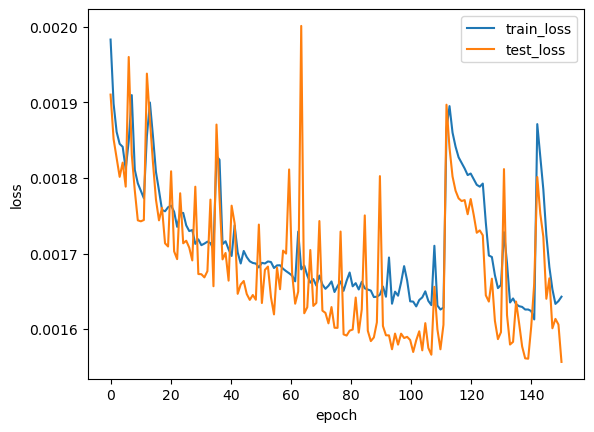

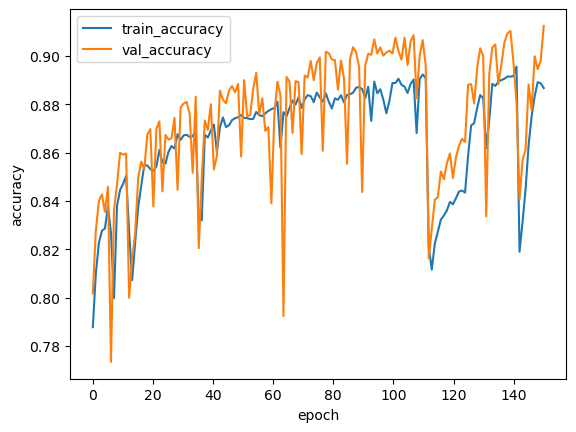

In [31]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [32]:
net.load_state_dict(torch.load("../weights/DiflNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

在测试集上的准确率为:0.897


In [33]:
def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

test precision: 0.8791183557402545  test recall: 0.8696927701559024  test f1_score: 0.8738074219143936
